# Autocorrelation and ARIMA

We've seen the concepts of correlation and cointegration. We're going to put them in practice to finally be able to do some forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
def stationarity_check(time_series, cutoff=0.05):
    result = adfuller(time_series)
    p_value = result[1]
    stat_msg = 'non-stationary'

    if p_value < cutoff:
        stat_msg = 'stationary'
        
    print("P-value = {:.13f}. Data is likely {}".format(p_value, stat_msg))

### Autocorrelation

We're going to load our regular Toothbrush sales data to introduce autocorrelation.

In [5]:
tb = pd.read_csv(
    'data/tb-sales.csv',
    index_col=0,
    parse_dates=True
)

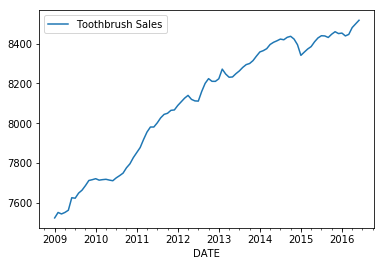

In [6]:
tb.plot()

Autocorrelation will work better if we make the TS stationary, so we'll take the first difference (tb sales don't look seasonal).

In [8]:
tb['First Difference'] = tb['Toothbrush Sales'].diff()

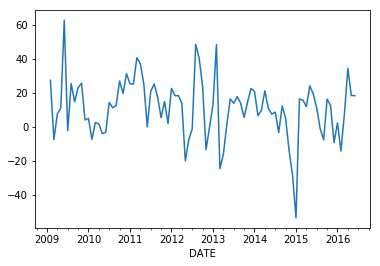

In [9]:
tb['First Difference'].plot()

In [10]:
stationarity_check(tb['First Difference'].dropna())

P-value = 0.0000000020295. Data is likely stationary


Now that we've made it stationary, we can check the autocorrelation **of the "stationarized" ts**; that is, of our stationary first difference. From now on, we'll work with this ts instead of the original one.

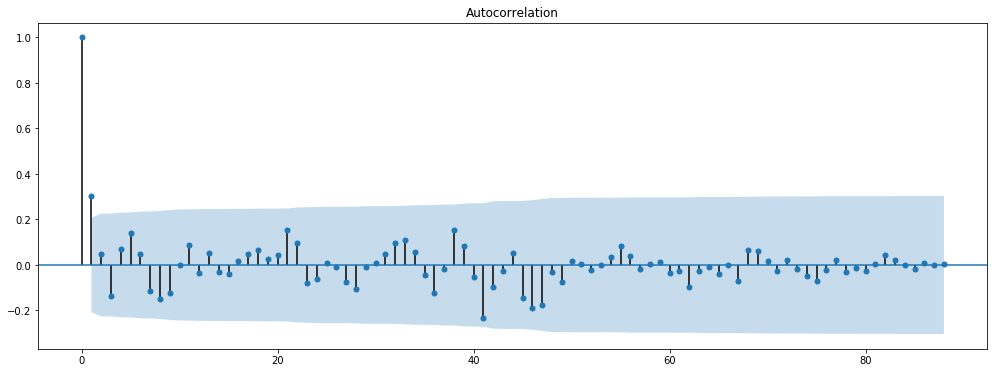

In [89]:
fig, ax = plt.subplots(figsize=(17, 6))
plot_acf(tb['First Difference'].dropna(), ax=ax);

Autocorrelation measures the correlation of a timeseries with itself. The blue area you see is the mark when "autocorrelation gets statistically insignificant", that is, we can't say the TS is correlated in any way past that point.

A TS has always a perfect correlation with itself, obviously. That's why the first point is 1.

The chart above has a sudden drop after the first point. The second lag shows some statistically significant correlation (close to .3) but it's still below anything meaningful.

## Partial Autocorrelation

Partial autocorrelation will be used when we have seasonal data. We'll introduce it with an example. We'll first load the Milk Production Dataset ([source](https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line)), a highly seasonal dataset (with less trend than our bookings one).

In [95]:
milk_prod = pd.read_csv(
    'data/monthly-milk-production-pounds-p.csv',
    index_col=0,
    header=None,
    names=['Date', 'Milk Production'],
    parse_dates=True)
milk_prod.head()

,Milk Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


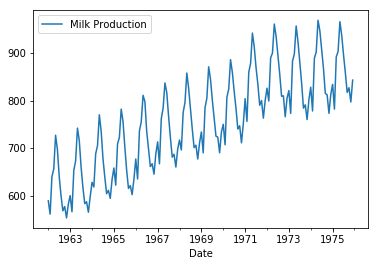

In [97]:
milk_prod.plot()

In [99]:
milk_prod['First Difference'] = milk_prod['Milk Production'].diff()

In [105]:
stationarity_check(milk_prod['First Difference'].dropna())

P-value = 0.0300680040018. Data is likely stationary


And now we'll plot the Autocorrelation plot:

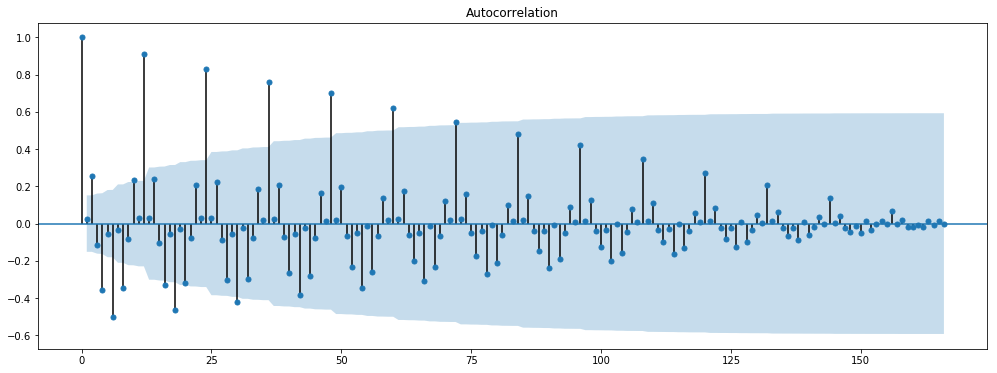

In [103]:
fig, ax = plt.subplots(figsize=(17, 6))
plot_acf(milk_prod['First Difference'].dropna(), ax=ax);

As you can see, there's a slow decay, not a sharp drop-off as in our previous example. This is because of the seasons. The time series tends to be correlated after X periods (where the seasonality is happening).

The solution for this is an Partial autocorrelation plot. Partial autocorrelation will try to obviate the seasonality component of our data.

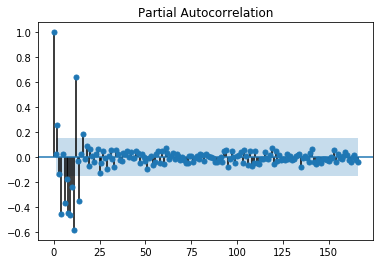

In [113]:
plot_pacf(milk_prod['First Difference'].dropna(), method='ywm');

There seem to be some inconsistencies, and this is likely related to the way we have differenced our dataset. As this is seasonal data, we'll probably be better by taking a Seasonal Difference:

In [106]:
milk_prod['Seasonal Difference'] = milk_prod['Milk Production'].diff(12)

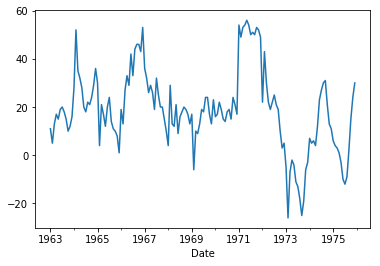

In [107]:
milk_prod['Seasonal Difference'].plot()

But this hasn't achieved our stationarity yet:

In [108]:
stationarity_check(milk_prod['Seasonal Difference'].dropna())

P-value = 0.1607988052771. Data is likely non-stationary


So we might need to take the seasonal difference, **out of our first difference**:

In [109]:
milk_prod['Seasonal First Difference'] = milk_prod['First Difference'].diff(12)

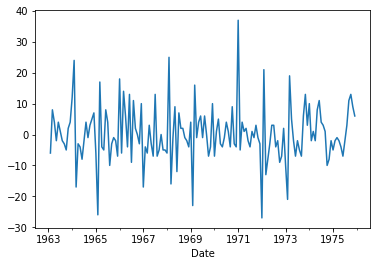

In [110]:
milk_prod['Seasonal First Difference'].plot()

In [111]:
stationarity_check(milk_prod['Seasonal First Difference'].dropna())

P-value = 0.0000186542343. Data is likely stationary


And now we've achieved stationarity :)

Back to our partial autocorrelation plots:

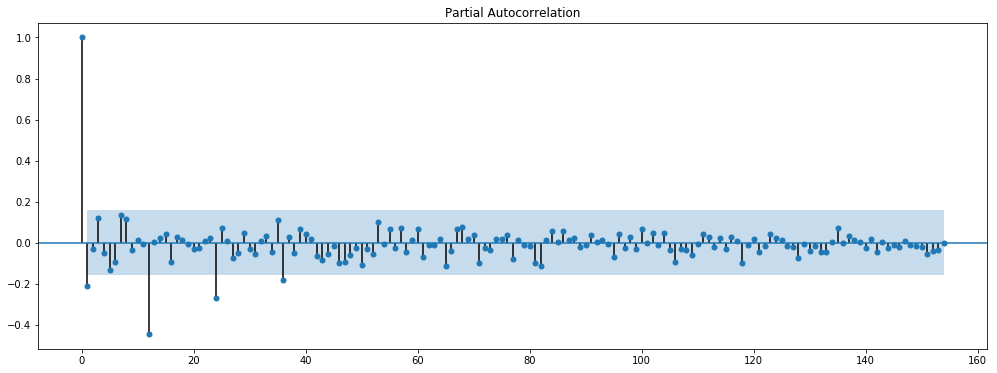

In [117]:
fig, ax = plt.subplots(figsize=(17, 6))
plot_pacf(milk_prod['Seasonal First Difference'].dropna(), ax=ax, method='ywm');

It now looks a lot better in terms of autocorrelation.

# ARIMA

An ARIMA model has 3 main components:
* AR: Auto Regressive
* I: Integrated (differenced)
* MA: Moving Average

and is a generalization of the ARMA model (autoregressive, moving average).

An ARIMA model is constructed using 3 parameters: `p`, `d` and `q`, each one corresponding to the `AR`, `I` and `MA` portions of the model.

Selecting these parameters is the most challenging process. We'll use the autocorrelation plots of that. Let's get started with our toothbrush sales (we'll use a **seasonal** ARIMA for our milk production dataset).

In [118]:
from statsmodels.tsa.arima_model import ARIMA

This is a summary of all we did with our toothbrush sales dataset: we computed the first difference (integration of order 1), check stationarity and then plotted the autocorrelation:

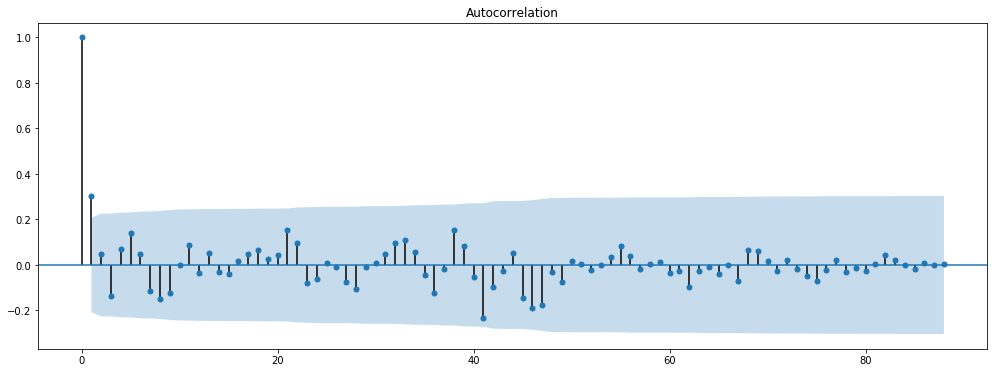

In [120]:
fig, ax = plt.subplots(figsize=(17, 6))
plot_acf(tb['First Difference'].dropna(), ax=ax);

We see a sharp drop-off after the first period. This is going to be important. We also know that we took the **first difference** to make the process stationary. We'll use these two parameters to construct our ARIMA model:

In [206]:
model = ARIMA(tb['Toothbrush Sales'], order=(2, 1, 0))

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [207]:
results = model.fit(disp=0)

In [208]:
forecast = pd.Series(
    results.forecast(12)[0], name='Forecast',
    index=pd.date_range(start=tb.index.max(), freq='MS', periods=12)
)
forecast

2016-06-01    8530.558813
2016-07-01    8542.057012
2016-08-01    8553.301298
2016-09-01    8564.551193
2016-10-01    8575.816170
2016-11-01    8587.085659
2016-12-01    8598.355795
2017-01-01    8609.625901
2017-02-01    8620.895964
2017-03-01    8632.166014
2017-04-01    8643.436063
2017-05-01    8654.706112
Freq: MS, Name: Forecast, dtype: float64

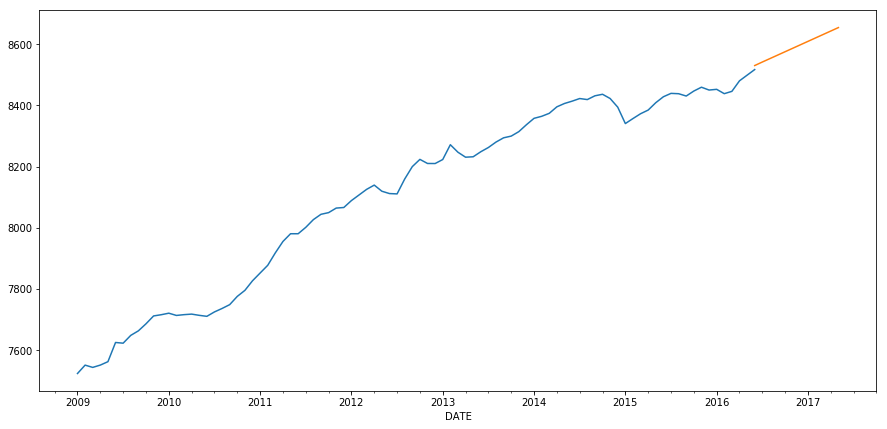

In [209]:
fig, ax = plt.subplots(figsize=(15, 7))

tb['Toothbrush Sales'].plot(fig=fig)
forecast.plot(fig=fig)

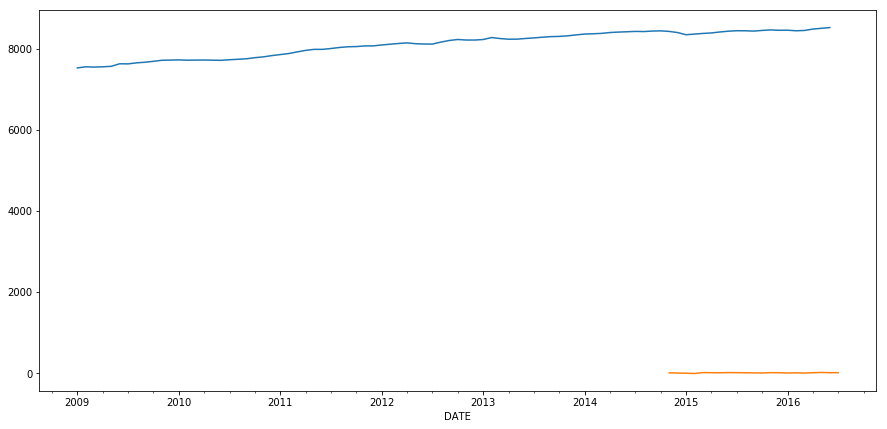

In [210]:
fig, ax = plt.subplots(figsize=(15, 7))

tb['Toothbrush Sales'].plot(fig=fig)
results.predict(start=70, end=90, dynamic=False).plot(fig=fig)

These are the "residuals" of our model; basically, the error. Usually suggesting that there may still be some trend information not captured by the model.

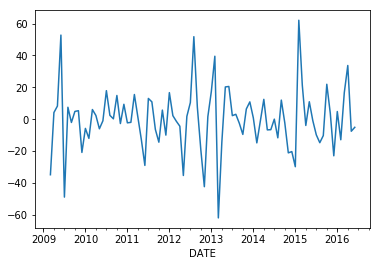

In [148]:
results.resid.plot()

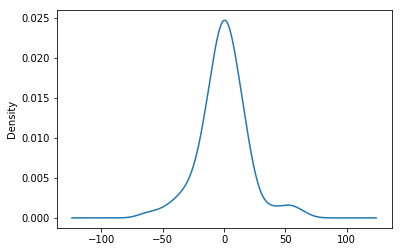

In [149]:
results.resid.plot(kind='kde')

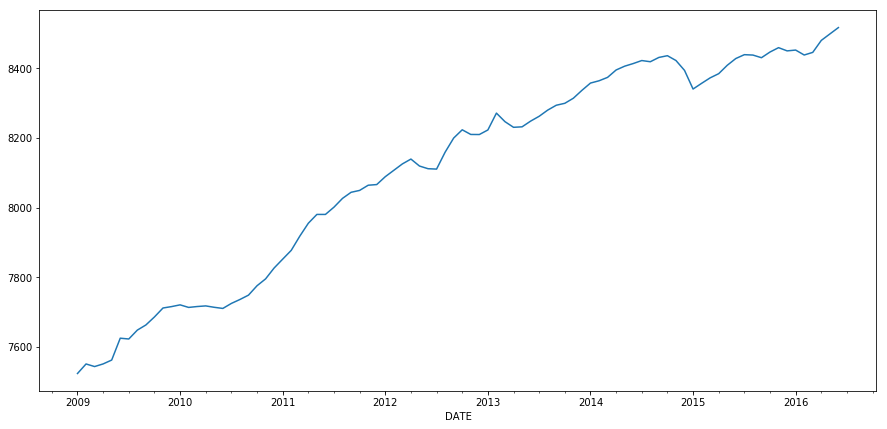

In [150]:
fig, ax = plt.subplots(figsize=(15, 7))
#
tb['Toothbrush Sales'].plot(fig=fig)

In [151]:
results.predict(start=70, end=90, dynamic= True)

2014-11-01    2.274385
2014-12-01   -0.721639
2015-01-01    0.214608
2015-02-01   -0.077966
2015-03-01    0.013462
2015-04-01   -0.015109
2015-05-01   -0.006181
2015-06-01   -0.008971
2015-07-01   -0.008099
2015-08-01   -0.008371
2015-09-01   -0.008286
2015-10-01   -0.008313
2015-11-01   -0.008304
2015-12-01   -0.008307
2016-01-01   -0.008306
2016-02-01   -0.008307
2016-03-01   -0.008306
2016-04-01   -0.008306
2016-05-01   -0.008306
2016-06-01   -0.008306
2016-07-01   -0.008306
Freq: MS, dtype: float64

In [9]:
df = pd.read_csv(
    'data/monthly-milk-production-pounds-p.csv',
    index_col=0,
    header=None,
    names=['Date', 'Milk Production'],
    parse_dates=True)
df.head()

,Milk Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Milk Production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


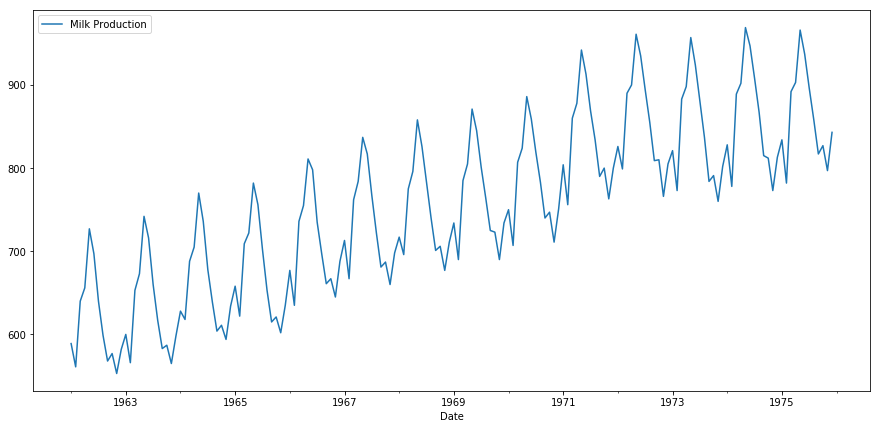

In [11]:
df.plot(figsize=(15, 7))

In [12]:
df['First Difference'] = df['Milk Production'].diff()

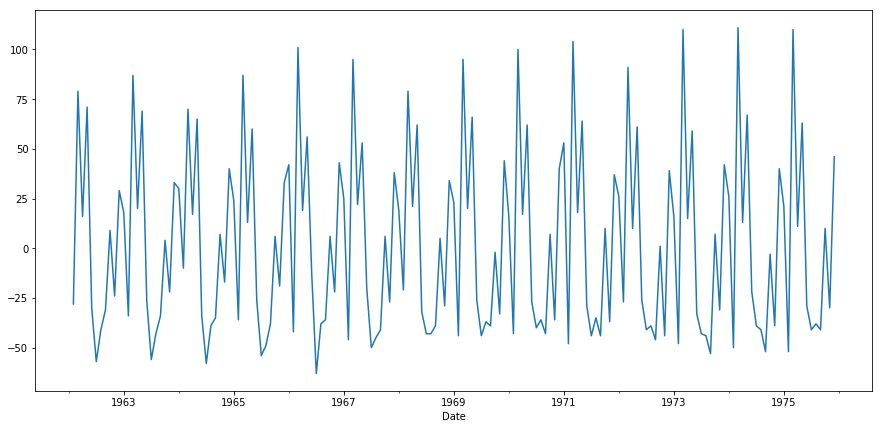

In [14]:
df['First Difference'].plot(figsize=(15, 7))

In [19]:
stationarity_check(df['First Difference'].dropna())

P-value = 0.0300680040018. Data is likely stationary


In [20]:
df['Seasonal Difference'] = df['Milk Production'].diff(12)

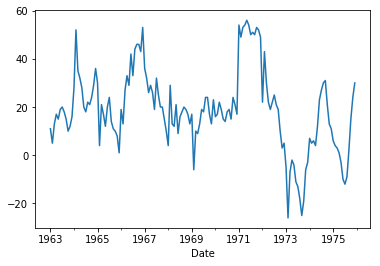

In [21]:
df['Seasonal Difference'].plot()

In [23]:
stationarity_check(df['Seasonal Difference'].dropna())

P-value = 0.1607988052771. Data is likely non-stationary


In [27]:
df['Seasonal First Difference'] = df['First Difference'].diff(12)

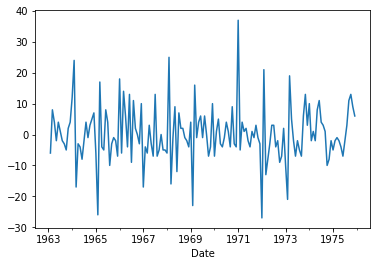

In [28]:
df['Seasonal First Difference'].plot()

In [29]:
stationarity_check(df['Seasonal First Difference'].dropna())

P-value = 0.0000186542343. Data is likely stationary


### Autocorrelation

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

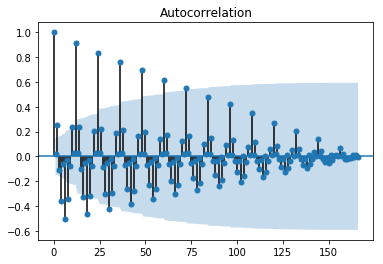

In [32]:
plot_acf(df["First Difference"].dropna());

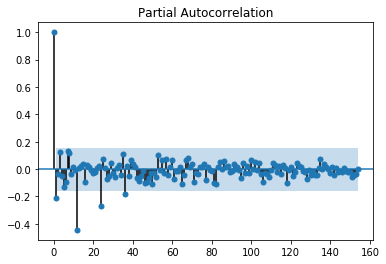

In [56]:
plot_pacf(df["Seasonal First Difference"].dropna(), method='ywm');

## ARIMA Models

In [59]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [60]:
model = sm.tsa.statespace.SARIMAX(df['Milk Production'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                    Milk Production   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 20 Jul 2018   AIC                           1074.131
Time:                                    00:13:27   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

In [61]:
df.tail()

,Milk Production,First Difference,Seasonal Difference,Seasonal First Difference
Date,,,,
1975-08-01,858,-38.0,-9.0,3.0
1975-09-01,817,-41.0,2.0,11.0
1975-10-01,827,10.0,15.0,13.0
1975-11-01,797,-30.0,24.0,9.0
1975-12-01,843,46.0,30.0,6.0


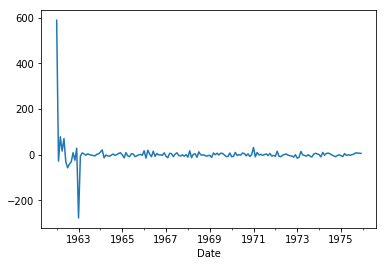

In [78]:
results.resid.plot()

### Predictions

In [83]:
results.predict(start = 150, end= 168, dynamic= True)

1974-07-01    904.057179
1974-08-01    863.899101
1974-09-01    816.824729
1974-10-01    822.142915
1974-11-01    786.672698
1974-12-01    826.628031
1975-01-01    851.771012
1975-02-01    807.354425
1975-03-01    912.267843
1975-04-01    926.505912
1975-05-01    989.604710
1975-06-01    962.944934
1975-07-01    919.999545
1975-08-01    879.668974
1975-09-01    832.328553
1975-10-01    837.722249
1975-11-01    802.452736
1975-12-01    842.499869
1976-01-01    867.681329
Freq: MS, dtype: float64

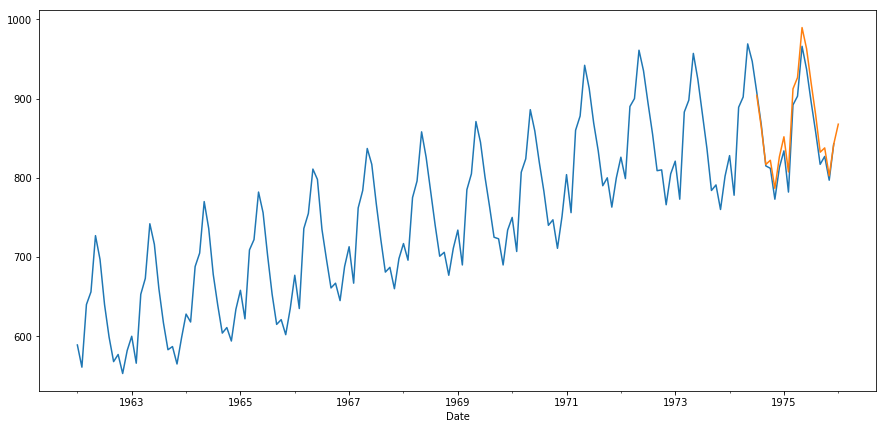

In [84]:
fig, ax = plt.subplots(figsize=(15, 7))
df['Milk Production'].plot(fig=fig)
results.predict(start = 150, end= 168, dynamic= True).plot(fig=fig)